<a href="https://colab.research.google.com/github/ynes99/fire-detection/blob/main/yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports
ref : https://colab.research.google.com/github/luxonis/depthai-ml-training/blob/master/colab-notebooks/YoloV3_V4_tiny_training.ipynb#scrollTo=fwRcypwSxdnw

In [ ]:
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf #choosing tensorflow version
tf.__version__
from shutil import copyfile
import os
import shutil
from google.colab import drive
import re
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import inspect
import random
import sys

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Utilities:

In [ ]:

def extract_log(log_file,new_log_file,key_word):
    with open(log_file, 'r') as f:
      with open(new_log_file, 'w') as train_log:
  #f = open(log_file)
    #train_log = open(new_log_file, 'w')
        for line in f:
          if 'Syncing' in line:
            continue
          if 'nan' in line:
            continue
          if 'Region 82 Avg' in line:
            continue
          if 'Region 94 Avg' in line:
            continue
          if 'Region 106 Avg' in line:
            continue
          if 'total_bbox' in line:
            continue  
          if 'Loaded' in line:
            continue              
          if key_word in line:
            train_log.write(line)
    f.close()
    train_log.close()

def extract_log2(log_file,new_log_file,key_word):
    with open(log_file, 'r') as f:
      with open(new_log_file, 'w') as train_log:
  #f = open(log_file)
    #train_log = open(new_log_file, 'w')
        for line in f:
          if 'Syncing' in line:
            continue
          if 'nan' in line:
            continue
          if 'Region 94 Avg' in line:
            continue
          if 'Region 106 Avg' in line:
            continue
          if 'total_bbox' in line:
            continue  
          if 'Loaded' in line:
            continue     
          if 'IoU: 0.000000' in line:
            continue                          
          if key_word in line:
            del_num=line.replace("v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (", "")
            train_log.write(del_num.replace(")", ""))
          
    f.close()
    train_log.close() 

In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

## 1. Mount the drive

In [ ]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
%cd MyDrive/Dataset_fire_detection

/gdrive/MyDrive/Dataset_fire_detection


In [ ]:
%ls

 annotation/             data/                 trainTinyYolov4_f.log
 backup/                'faster r cnn logs'/   trainYv4_2.log
 cfg_files/              Fire-detection-2/     weights/
 chart_yolov3.png        imgs/                'yolov3 logs'/
 chart_yolov4.png        metadata1.6.csv       yolov3_tiny_logs/
 chart_yolov4-tiny.png   obj.data              yolov4_logs/
 classes.txt             obj_test.data         yolov4_tiny_logs/
 darknet/                README.txt           'yolov5 logs'/


##2. Setting up Darknet

In [ ]:
%%capture
!git clone https://github.com/AlexeyAB/darknet.git

In [ ]:
%cd darknet

/gdrive/MyDrive/Dataset_fire_detection/darknet


In [ ]:

!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make


chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!chmod +x ./darknet

In [ ]:
%ls

 3rdparty/                core                     net_cam_v3.sh
 anchors.txt              counters_per_class.txt   net_cam_v4.sh
 backup/                  darknet*                 obj/
 bad.list                 DarknetConfig.cmake.in   README.md
 build/                   darknet_images.py        results/
 build.ps1                darknet.py               scripts/
 cfg/                     darknet_video.py         src/
 chart.png                data/                    train.log
 chart_yolov3-tiny.png    image_yolov3.sh          trainYv4.log
 chart_yolov4.png         image_yolov4.sh          vcpkg.json
 chart_yolov4-tiny.png    include/                 video_yolov3.sh
 cmake/                   json_mjpeg_streams.sh    video_yolov4.sh
 CMakeLists.txt           LICENSE
'Copie de train V2.log'   Makefile


## Dataset

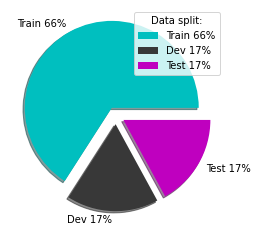

In [ ]:
y = np.array([723, 187, 187])
mylabels = ["Train 66%", "Dev 17%", "Test 17%"]
myexplode = [0.1, 0.1, 0.1]
mycolors = ["c", "#383838", "m"]
plt.pie(y, labels = mylabels, explode = myexplode, shadow = True,colors=mycolors)
plt.legend(title = "Data split:")
plt.show() 

## 4. Train preparation

### 4.1 Download weights for YoloV3

In [ ]:
%ls

 annotation/   data/             obj_test.data     yolov3-tiny.conv.15
 backup/       imgs/             README.txt       'yolov3 tiny logs'/
 classes.txt   metadata1.5.csv  'yolov3 logs'/
 darknet/      obj.data          yolov3-tiny.cfg


In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-07-01 13:34:24--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  37.1MB/s    in 4.7s    

2022-07-01 13:34:29 (32.9 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



### 4.2 obj.names
We create the `obj.names`. Each line must be its own text label.

In [ ]:
labels = ['fire']

In [ ]:
labels_path = r"/gdrive/MyDrive/Dataset_fire_detection/data/obj.names"

with open(labels_path, 'w') as f:
    f.write('\n'.join(labels))

#check that the labels file is correct
!cat "/gdrive/MyDrive/Dataset_fire_detection/data/obj.names"

fire

### 4.3 obj.data

We set up `obj.data`, which needs to include the number of classes, paths to train, validation, and test *txts*, path to the *obj.names*, and the name of the folder where weights will be saved.




In [ ]:
#the number of classes is equal to the number of labels
num_classes = len(labels)


In [ ]:
objdata = '/gdrive/MyDrive/Dataset_fire_detection/obj.data'


with open(objdata, 'w') as f:
  f.write(f"classes = {num_classes}\n")
  f.write(f"train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt\n") 
  f.write(f"valid = /gdrive/MyDrive/Dataset_fire_detection/data/dev.txt\n") 
  f.write(f"names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names\n")
  f.write(f"backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup")


In [ ]:
!cat '/gdrive/MyDrive/Dataset_fire_detection/obj.data'

classes = 1
train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt
valid = /gdrive/MyDrive/Dataset_fire_detection/data/dev.txt
names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names
backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup

In [ ]:
objdata = '/gdrive/MyDrive/Dataset_fire_detection/obj_test.data'

#the number of classes is equal to the number of labels
num_classes = len(labels)

with open(objdata, 'w') as f:
  f.write(f"classes = {num_classes}\n")
  f.write(f"train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt\n") 
  f.write(f"valid = /gdrive/MyDrive/Dataset_fire_detection/data/test.txt\n") 
  f.write(f"names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names\n")
  f.write(f"backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup")

In [ ]:
!cat '/gdrive/MyDrive/Dataset_fire_detection/obj_test.data'

classes = 1
train = /gdrive/MyDrive/Dataset_fire_detection/data/train.txt
valid = /gdrive/MyDrive/Dataset_fire_detection/data/test.txt
names = /gdrive/MyDrive/Dataset_fire_detection/data/obj.names
backup = /gdrive/MyDrive/Dataset_fire_detection/darknet/backup

### 4.4 Config file

In [ ]:
%ls

 annotation/   darknet53.conv.74   obj.data       'yolov3 logs'/
 backup/       data/               obj_test.data   yolov3-tiny.cfg
 classes.txt   imgs/               README.txt      yolov3-tiny.conv.15
 darknet/      metadata1.5.csv     yolov3.cfg     'yolov3 tiny logs'/


In [ ]:
!cp '/gdrive/MyDrive/Dataset_fire_detection/darknet/cfg/yolov3.cfg' '/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3.cfg'

In [ ]:
cfg_file = f'/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3.cfg'
cfg_file

'/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3.cfg'

In [ ]:
weights_file = '/gdrive/MyDrive/Dataset_fire_detection/weights/darknet53.conv.74 '
weights_file

'/gdrive/MyDrive/Dataset_fire_detection/weights/darknet53.conv.74 '

#### 4.4.1 Setting parameters

You can set a custom height and width, as long as they are both divisible by *32*.

**Other parameters**

We set other parameters according to [this tutorial](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects).

In [ ]:
labels = ['fire']
num_classes = len(labels)

In [ ]:
# must be divisible by 32
#yolo_height = 320
#yolo_width = 512

# set the number of max_batches - min 2000 per class:
max_batch = num_classes * 2500
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3

batch = 64
subdivisions = 16 #4 images per iteration how many iterations ? plot the epochs
burn_in = 100
#learning_rate = 0.00075


In [ ]:
num_filters

18

#### 4.4.2 parameters of config
It's how many mini batches you split your batch in.  
`Batch=64 -> loading 64 images for this "iteration"`.
`Subdivision=8 -> Split batch into 8 "mini-batches"`   
So 64/8 = 8 images per "minibatch" and this get sent to the gpu for process.
That will be repeated 8 times until the batch is completed and a new itereation will start with 64 new images.

*When batching you are averaging over more images the intend is not only to speed up the training process but also to generalise the training more.* -The more you know 🧠

If your GPU have enough memory you can reduce the subdivision to load more images into the gpu to process at the same time.  
Total of images in train set :  723 images 
CL :  
dataset = 723 samples = 1 epoch  
batch = 64  
subdivisions = mini-batches = 16  
1 epoch = 12 iterations = 723/64  
1 iteration = 16 mini-batches = 1 batch  
mini-batch size = 64/16 = 4 samples  

In [ ]:
%ls

 annotation/           metadata1.6.csv      'yolov3 tiny logs'/
 backup/               obj.data              yolov4.cfg
 classes.txt           obj_test.data         yolov4.conv.137
 darknet/              README.txt           'yolov4 logs'/
 darknet53.conv.74     train.log             yolov4-tiny.cfg
 data/                 yolov3.cfg            yolov4-tiny.conv.29
'faster r cnn logs'/  'yolov3 logs'/        'yolov4 tiny logs'/
 imgs/                 yolov3-tiny.cfg      'yolov5 logs'/
 metadata1.5.csv       yolov3-tiny.conv.15


In [ ]:
with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
s = re.sub('batch=\d*', 'batch='+str(batch), s)
s = re.sub('subdivisions=\d*', 'subdivisions='+str(subdivisions), s)
#s = re.sub('height=\d*', 'height='+str(yolo_height), s)
#s = re.sub('width=\d*', 'width='+str(yolo_width), s)
# s = re.sub('burn_in=\d*', 'burn_in='+str(burn_in), s)
# s = re.sub('learning_rate=\d*','learning_rate='+str(learning_rate),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



We inspect the config file and check whether the parameters were set correctly.


In [ ]:
!head -n 24 '/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3.cfg'

[net]
# Testing
batch=64
subdivisions=16
# Training
# batch=64
# subdivisions=16
width=512
height=320
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00075
burn_in=100
max_batches = 2500
policy=steps
steps=2000,2250
scales=.1,.1



We also inspect the last few lines to see if the number of filters in [convolutional] before [yolo] is correct.

In [ ]:
!cat  '/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3.cfg'

[net]
# Testing
batch=64
subdivisions=16
# Training
# batch=64
# subdivisions=16
width=320
height=320
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 2500
policy=steps
steps=2000,2250
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
b

## Training time

We set up all the things that we need for training.

As we are training with -map flag, we will get the best weights saved in backup/ directory with suffix best. Those will be the weights that give the highest mAP on the validation set, in order to prevent overfitting.



### V1 2500 batches
batches : *2500*

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file $weights_file -dont_show -map | tee trainyv3.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.769700), count: 2, class_loss = 0.006243, iou_loss = 0.056066, total_loss = 0.062308 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.654241), count: 5, class_loss = 1.083641, iou_loss = 0.609839, total_loss = 1.693480 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000876, iou_loss = 0.000000, total_loss = 0.000876 
 total_bbox = 237977, rewritten_bbox = 0.245402 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.854102), count: 6, class_loss = 0.556490, iou_loss = 0.197506, total_loss = 0.753996 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.767210), count: 1, class_loss = 0.369821, iou_loss = 0.053643, total_loss = 0.423464 
v3 (mse loss, Normalizer: (iou

batches : `2500 -> *3500*`

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file $weights_file -dont_show -map | tee trainyv3.log 2>&1

#### Loss




Use the extract_log script to convert your `.log` file to the appropriate format

Use the `train_loss_visualization.py` script to draw the loss curve

In [ ]:
p_dir = '/gdrive/MyDrive/Dataset_fire_detection/yolov3 logs/v2 2500batches 1000burn_in 408 408 images'
log_file = p_dir + '/trainY_v3_2500bat_burnin_1000.log'
dst_map = p_dir + '/map.txt'
dst_loss = p_dir +'/train_log_loss.txt'
path_loss = p_dir + '/train_log_loss.csv'
path_map = p_dir + '/map.csv'
# Extract logs
#extract_log(log_file ,dst_loss,'images')
#extract_log(log_file,dst_map,'mean average precision ')
#extract_log2(p_dir + '/trainY_v3_2500bat_burnin_1000.log',p_dir + '/train_log_iou.txt','IoU')
# reformat logs
with open (dst_loss, "r") as myfile:
    data = myfile.read().splitlines()
data = data[1::]
a = [line.split(',') for line in data]

In [ ]:
loss =[]
avg_l = []
rate = []
time = []
images = []
h_left = []
df = {'loss':loss,'avg loss':avg_l,'rate':rate,'time':time,'images':images,'hours_left':h_left}
for line in a : 
  n_line = []
  for ele,key in zip(line,df.keys()):
    if line.index(ele) == 0:
      df[key].append(ele.split(':')[1])
    else:
      df[key].append(ele.split()[0])

pd.DataFrame.from_dict(df).to_csv(path_loss,index = False)

In [ ]:
with open (dst_map, "r") as myfile:
    map = myfile.read().splitlines()

map = [line.split()[-2] for line in map]
print(map)
z = pd.DataFrame.from_dict({'mAP':map})
z.to_csv(path_map,index=False)

['43.13', '38.16', '47.02', '50.46', '54.94', '53.55', '53.88', '55.21', '51.15', '57.42', '54.32', '57.56', '57.17', '60.35', '57.54', '57.95']


In [ ]:
z = pd.read_csv(path_loss)
t_l = list(z['loss'])
a_l = list(z['avg loss'])
v_l=[]
v_l = [2*float(a)-float(t) for t, a in zip(t_l,a_l)]
z['valid loss']=v_l
z.to_csv(path_loss,index=False)

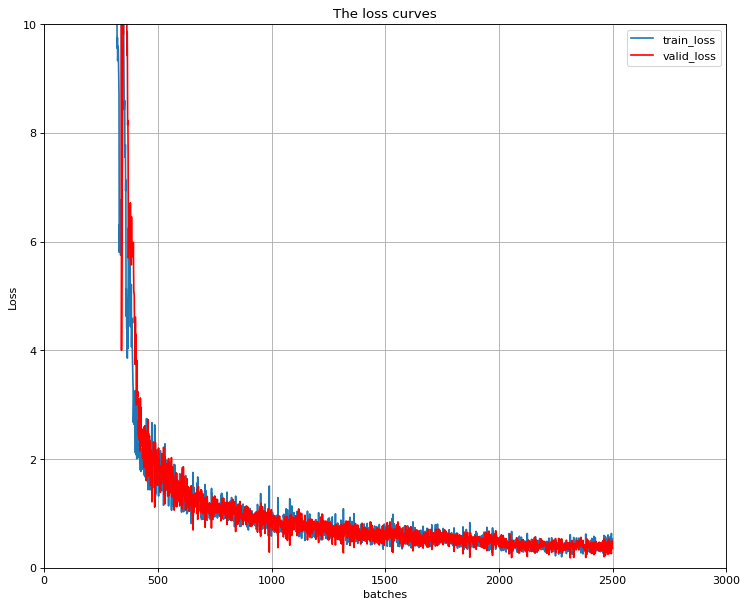

In [ ]:
#map the training loss and valid loss
df1 = pd.read_csv(path_loss)

m = list(df1['valid loss'])
m_prime = list(df1['loss'])
 
fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(m_prime, label = 'train_loss')
plt.plot(m, label = 'valid_loss',color='red') # bar can be replaced by
plt.ylim(0.0,10.00) 
plt.xlim(0,3000)
ax.set_title('The loss curves')
ax.set_ylabel('Loss')
ax.set_xlabel('batches')

plt.legend(loc='best')
# scatter or line or even left as default
plt.grid()
plt.show()

#### mAP

In [ ]:
df2 = pd.read_csv(path_map)
x = [i for i in range(1000, 2500+1, 100)]
y = list(df2['mAP'])
print(x,y)

[1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500] [43.13, 38.16, 47.02, 50.46, 54.94, 53.55, 53.88, 55.21, 51.15, 57.42, 54.32, 57.56, 57.17, 60.35, 57.54, 57.95]


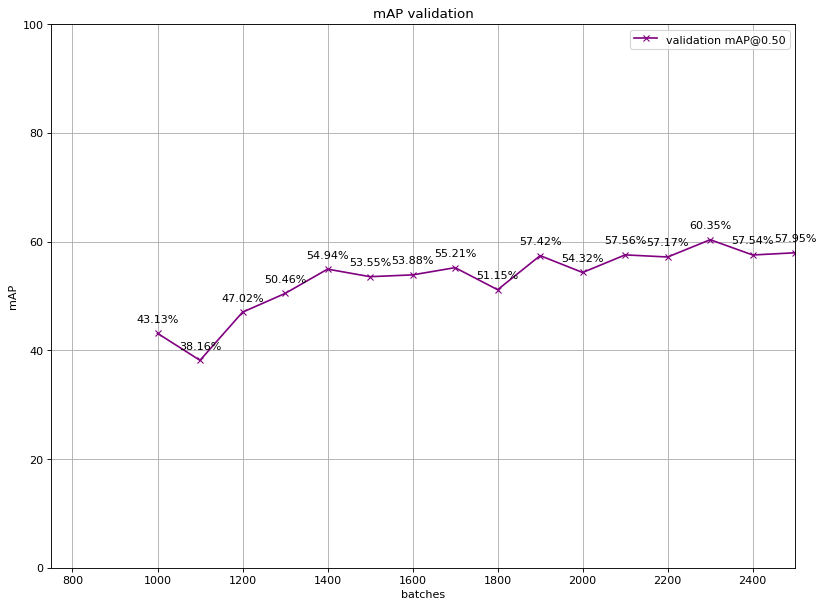

In [ ]:

fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(x,y, label = 'validation mAP@0.50',color ='purple',marker='x') # bar can be replaced by
plt.ylim(0.0,100.00) 
plt.xlim(750,2500)
ax.set_title('mAP validation')
ax.set_ylabel('mAP')
ax.set_xlabel('batches')
plt.legend(loc='best')

for i,j in zip(x,y):

    label = "{:.2f}".format(j)

    plt.annotate(label+'%', # this is the text
                 (i,j), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.grid()
# scatter or line or even left as default
plt.show()

### V2
[net]  
batch=64  
subdivisions=16  
width=512  
height=320  
channels=3  
momentum=0.9  
decay=0.0005  
angle=0  
saturation = 1.5  
exposure = 1.5  
hue=.1  

learning_rate=0.00075  
burn_in=100  
max_batches = 2500  
policy=steps  
steps=2000,2250  
scales=.1,.1  

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file '/gdrive/MyDrive/Dataset_fire_detection/darknet/backup/yolov3_last.weights' -dont_show -map | tee trainYolov3_ffP2.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.753513), count: 3, class_loss = 0.050711, iou_loss = 0.164172, total_loss = 0.214883 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.540362), count: 2, class_loss = 0.325352, iou_loss = 0.464260, total_loss = 0.789612 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.582323), count: 2, class_loss = 0.397882, iou_loss = 0.414266, total_loss = 0.812148 
 total_bbox = 188978, rewritten_bbox = 0.117474 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.714477), count: 3, class_loss = 0.268994, iou_loss = 0.130127, total_loss = 0.399121 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.584956), count: 1, class_loss = 0.304807, iou_loss = 0.109823, total_loss = 0.414630 
v3 (mse loss, Normalizer: (iou

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file $weights_file -dont_show -map | tee trainYolov3_f.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 total_bbox = 235463, rewritten_bbox = 0.121888 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.828184), count: 4, class_loss = 0.140318, iou_loss = 0.104365, total_loss = 0.244683 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.761008), count: 1, class_loss = 0.017482, iou_loss = 0.022010, total_loss = 0.039492 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.192777), count: 4, class_loss = 0.259423, iou_loss = 1.243715, total_loss = 1.503138 
 total_bbox = 235472, rewritten_bbox = 0.122308 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.799015), count: 3, class_loss = 0.112661, iou_loss = 0.075313, total_loss = 0.187974 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.716830), count: 3, class_loss = 0.480732, iou_loss = 0.336898, to

In [ ]:
!./darknet detector train '/gdrive/MyDrive/Dataset_fire_detection/obj.data' $cfg_file '/gdrive/MyDrive/Dataset_fire_detection/darknet/backup/yolov3_last.weights' -dont_show -map | tee trainYolov3_f_2400.log 2>&1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.679973), count: 1, class_loss = 0.145149, iou_loss = 0.115339, total_loss = 0.260488 
 total_bbox = 2864, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.770561), count: 3, class_loss = 0.103333, iou_loss = 0.234929, total_loss = 0.338261 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.510848), count: 3, class_loss = 0.554951, iou_loss = 0.962657, total_loss = 1.517609 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.681311), count: 1, class_loss = 0.241578, iou_loss = 0.106263, total_loss = 0.347842 
 total_bbox = 2871, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.794572), count: 4, class_loss = 0.650522, iou_loss = 0.164854, total

#### Loss

In [ ]:
p_dir = '/gdrive/MyDrive/Dataset_fire_detection/yolov3 logs/v3true'
log_file = p_dir + '/trainYolov3_ffP2.log'
dst_map = p_dir + '/map2.txt'
dst_loss = p_dir +'/train_log_loss2.txt'
path_loss = p_dir + '/train_log_loss2.csv'
path_map = p_dir + '/map2.csv'

In [ ]:
p_dir = '/gdrive/MyDrive/Dataset_fire_detection/yolov3 logs/v3true'
log_file = p_dir + '/trainYolov3_ffP2.log'
dst_map = p_dir + '/map2.txt'
dst_loss = p_dir +'/train_log_loss2.txt'
path_loss = p_dir + '/train_log_loss2.csv'
path_map = p_dir + '/map2.csv'
# Extract logs
extract_log(log_file ,dst_loss,'images')
extract_log(log_file,dst_map,'mean average precision ')
#extract_log2(p_dir + '/trainY_v3_2500bat_burnin_1000.log',p_dir + '/train_log_iou.txt','IoU')
# reformat logs
with open (dst_loss, "r") as myfile:
    data = myfile.read().splitlines()
data = data[1::]
a = [line.split(',') for line in data]

In [ ]:
loss =[]
avg_l = []
rate = []
time = []
images = []
h_left = []
df = {'loss':loss,'avg loss':avg_l,'rate':rate,'time':time,'images':images,'hours_left':h_left}
for line in a : 
  n_line = []
  for ele,key in zip(line,df.keys()):
    if line.index(ele) == 0:
      df[key].append(ele.split(':')[1])
    else:
      df[key].append(ele.split()[0])

pd.DataFrame.from_dict(df).to_csv(path_loss,index = False)

In [ ]:
with open (dst_map, "r") as myfile:
    map = myfile.read().splitlines()

map = [line.split()[-2] for line in map]
print(map)
z = pd.DataFrame.from_dict({'mAP':map})
z.to_csv(path_map,index=False)

['45.50', '46.82', '55.26', '51.21', '53.44', '56.05', '53.99', '55.52', '56.33', '54.48', '56.32', '52.82', '56.20', '55.32', '57.75', '56.24', '58.61', '58.25', '58.65', '57.83']


In [ ]:
z = pd.read_csv(path_loss)
t_l = list(z['loss'])
a_l = list(z['avg loss'])
v_l=[]
v_l = [2*float(a)-float(t) for t, a in zip(t_l,a_l)]
z['valid loss']=v_l
z.to_csv(path_loss,index=False)

In [ ]:
df1 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3_logs/v3true/train_log_loss1.csv')
df2 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3_logs/v3true/train_log_loss2.csv')
result = pd.concat([df1[:500], df2])
result.to_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3_logs/v3true/train_log_loss_f.csv',index=False)
result

,loss,avg loss,rate,time,images,hours_left,valid loss
0,2142.569336,2142.569336,0.000000,6.598388,64,-1.000000,2142.569336
1,2145.130615,2142.825439,0.000000,6.624934,128,15.613779,2140.520263
2,2148.274902,2143.370361,0.000000,6.706393,192,15.578268,2138.465820
3,2146.928711,2143.726074,0.000000,6.736475,256,15.540849,2140.523437
4,2144.826416,2143.836182,0.000000,6.882257,320,15.495964,2142.845948
...,...,...,...,...,...,...,...
1995,0.460031,0.465769,0.000008,7.758474,159744,0.175491,0.471507
1996,0.611114,0.480303,0.000008,7.852016,159808,0.173822,0.349492
1997,0.374125,0.469685,0.000008,7.776971,159872,0.172149,0.565245
1998,0.553067,0.478024,0.000008,7.797043,159936,0.170471,0.402981


In [ ]:
m = list(result['valid loss']) 
m_prime = list(result['loss'])

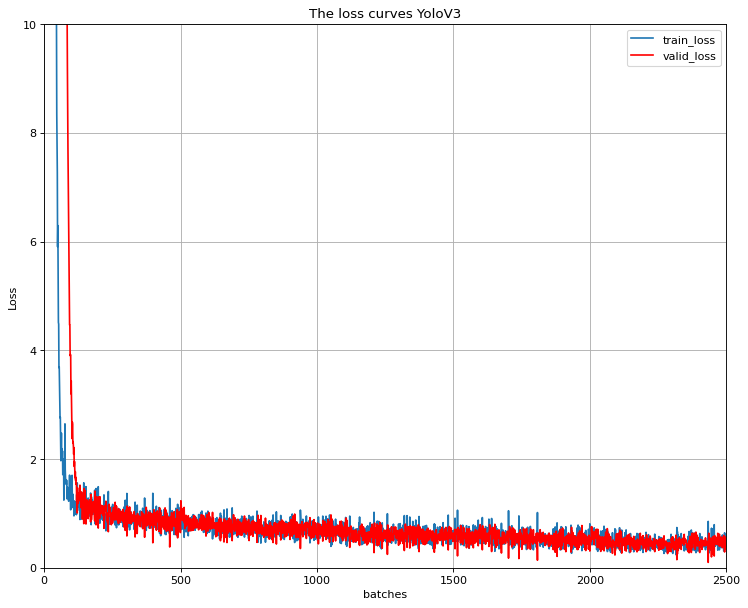

In [ ]:
#map the training loss and valid loss

fig = plt.figure(figsize=(11, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(m_prime, label = 'train_loss')
plt.plot(m, label = 'valid_loss',color='red') # bar can be replaced by
plt.ylim(0.0,10.00) 
plt.xlim(0,2500)
ax.set_title('The loss curves YoloV3')
ax.set_ylabel('Loss')
ax.set_xlabel('batches')

plt.legend(loc='best')
# scatter or line or even left as default
plt.grid()
plt.savefig('Yolov3 loss curves')
plt.show()

#### mAP

In [ ]:
df1 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3_logs/v3true/map1.csv')
df2 = pd.read_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3_logs/v3true/map2.csv')
result_m = pd.concat([df1, df2])
result.to_csv('/gdrive/MyDrive/Dataset_fire_detection/yolov3_logs/v3true/map_f.csv',index=False)

x = [i for i in range(100, 2500+1, 100)]
y = list(result_m['mAP'])
print(x,y)


[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500] [2.98, 23.37, 36.15, 48.34, 44.74, 45.5, 46.82, 55.26, 51.21, 53.44, 56.05, 53.99, 55.52, 56.33, 54.48, 56.32, 52.82, 56.2, 55.32, 57.75, 56.24, 58.61, 58.25, 58.65, 57.83]


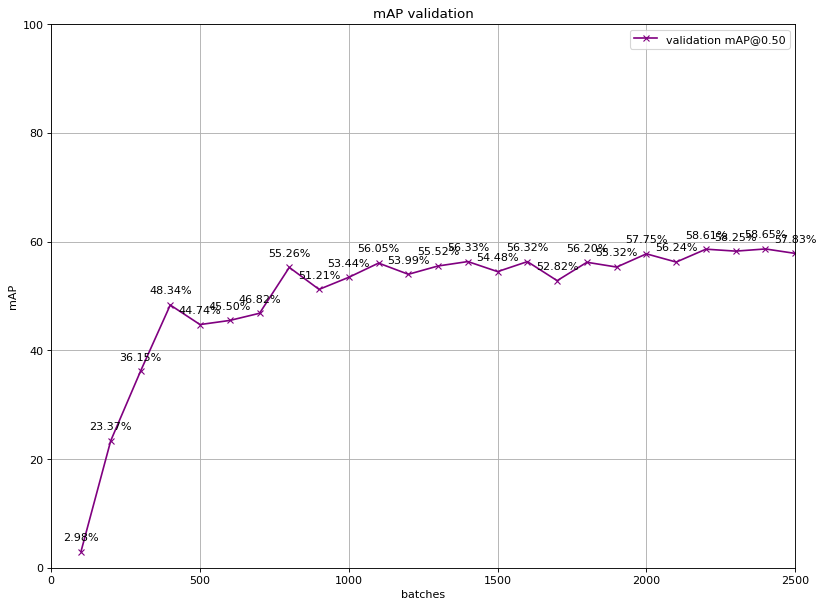

In [ ]:
fig = plt.figure(figsize=(12, 9), dpi=80)
ax = fig.add_subplot(1, 1, 1)
plt.plot(x,y, label = 'validation mAP@0.50',color ='purple',marker='x') # bar can be replaced by
plt.ylim(0.0,100.00) 
plt.xlim(0,2500)
ax.set_title('mAP validation')
ax.set_ylabel('mAP')
ax.set_xlabel('batches')
plt.legend(loc='best')

for i,j in zip(x,y):

    label = "{:.2f}".format(j)

    plt.annotate(label+'%', # this is the text
                 (i,j), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.grid()
# scatter or line or even left as default
plt.savefig('Yolov3 mAP validation.png')
plt.show()

## Testing and evaluation

In [ ]:
weights_best = "/gdrive/MyDrive/Dataset_fire_detection/yolov3_logs/v3true/yolov3_best.weights"
weights_best

cfg_file = '/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3.cfg'
cfg_file

'/gdrive/MyDrive/Dataset_fire_detection/cfg_files/yolov3.cfg'

In [ ]:
with open('/gdrive/MyDrive/Dataset_fire_detection/data/test.txt', 'r') as f:
    myTest = [line.strip() for line in f]

In [ ]:
print(myTest)

['/gdrive/MyDrive/Dataset_fire_detection/data/Test/003_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/004_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/006_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/007_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/011_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/012_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/015_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/016_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/021_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/030_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/040_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/042_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/057_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/067_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection/data/Test/069_rgb.png', '/gdrive/MyDrive/Dataset_fire_detection

In [ ]:
!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file $weights_best '/gdrive/MyDrive/Dataset_fire_detection/data/Test/004_rgb.png' -ext_output

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  32 0.283 BF
   1 conv     64       3 x 3/ 2    512 x 320 x  32 ->  256 x 160 x  64 1.510 BF
   2 conv     32       1 x 1/ 1    256 x 160 x  64 ->  256 x 160 x  32 0.168 BF
   3 conv     64       3 x 3/ 1    256 x 160 x  32 ->  256 x 160 x  64 1.510 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 256 x 160 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    256 x 160 x  64 ->  128 x  80 x 128 1.510 BF
   6 conv     64       1 x 1/ 1    128 x  80 x 128 ->  128 x  80 x  64 0.168 BF
   7 conv    128       3 x 3/ 1    128 x  80 x  64 ->  128 x  80 x 128 1.51

In [ ]:
for c in range(len(myTest)):
  test_im = myTest[c]
  new_name = myTest[c].split('/')[-1]

  !./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best $test_im -ext_output

  print('Done predicting !')

  test_im = ''.join(test_im.split('\\'))
  src = '/gdrive/MyDrive/Dataset_fire_detection/darknet/predictions.jpg'
  file_name = '/gdrive/MyDrive/Dataset_fire_detection/darknet'

  new_name = test_im.split('/')[-1]
  new_src = os.path.join(file_name,new_name)

  file_dst = '/gdrive/MyDrive/Dataset_fire_detection/data/yolov3_results'
  dst = os.path.join(file_dst,new_name)
  print('')

  os.rename(src, new_src)
  print(f'renaming {src} ========> {new_src}')
  print('__________________')
  shutil.move(new_src, dst)
  print(f'moving from {new_src} =========> {dst}\n')
  print('__________________')
  print('__________________')



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  72 conv    512       1 x 1/ 1     16 x  10 x1024 ->   16 x  10 x 512 0.168 BF
  73 conv   1024       3 x 3/ 1     16 x  10 x 512 ->   16 x  10 x1024 1.510 BF
  74 Shortcut Layer: 71,  wt = 0, wn = 0, outputs:  16 x  10 x1024 0.000 BF
  75 conv    512       1 x 1/ 1     16 x  10 x1024 ->   16 x  10 x 512 0.168 BF
  76 conv     18       3 x 3/ 1     16 x  10 x 512 ->   16 x  10 x  18 0.027 BF
  77 conv    512       1 x 1/ 1     16 x  10 x  18 ->   16 x  10 x 512 0.003 BF
  78 conv     18       3 x 3/ 1     16 x  10 x 512 ->   16 x  10 x  18 0.027 BF
  79 conv    512       1 x 1/ 1     16 x  10 x  18 ->   16 x  10 x 512 0.003 BF
  80 conv     18       3 x 3/ 1     16 x  10 x 512 ->   16 x  10 x  18 0.027 BF
  81 conv     18       1 x 1/ 1     16 x  10 x  18 ->   16 x  10 x  18 0.000 BF
  82 yolo
[yolo] params: iou loss: mse (2), iou_norm: 0.75, obj_norm: 1.00, cls_norm: 1.00, delta_norm: 1.00, scale_x_y: 1.00


### RESULT.TXT

In [ ]:
!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best -dont_show -ext_output < /gdrive/MyDrive/Dataset_fire_detection/data/test.txt > result.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     32 x  20 x 128 ->   32 x  20 x 256 0.377 BF
   9 max                2x 2/ 2     32 x  20 x 256 -> 

### RESULT.JSON

In [ ]:
!./darknet detector test /gdrive/MyDrive/Dataset_fire_detection/obj_test.data  $cfg_file  $weights_best -ext_output -dont_show -out result.json < /gdrive/MyDrive/Dataset_fire_detection/data/test.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    512 x 320 x   3 ->  512 x 320 x  16 0.142 BF
   1 max                2x 2/ 2    512 x 320 x  16 ->  256 x 160 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    256 x 160 x  16 ->  256 x 160 x  32 0.377 BF
   3 max                2x 2/ 2    256 x 160 x  32 ->  128 x  80 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    128 x  80 x  32 ->  128 x  80 x  64 0.377 BF
   5 max                2x 2/ 2    128 x  80 x  64 ->   64 x  40 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     64 x  40 x  64 ->   64 x  40 x 128 0.377 BF
   7 max                2x 2/ 2     64 x  40 x 128 ->   32 x  20 x 128